# SN Global

This notebook is a detailed work through showing how the Signal-to-Noise is calulcated. The methods outlined below are by no means as the final method used, but are just to show working

This notebook contains:
* First analysis of SN on global level.
* Sample plots prooving the S/N method works.
* Plots useful for presentations outlining how the method works.


# Preamble

In [1]:
import numpy as np
import os
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import xarray as xr
from importlib import reload
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from dask.diagnostics import ProgressBar

In [2]:
import sys
import constants
sys.path.append(constants.MODULE_DIR)
import xarray_class_accessors as xca
import sn_plotting as sn_plot

In [3]:
# The directory where all of the longrun mip data used in this notebook is stored.
ROOT_DIR = constants.LONGRUNMIP_RETIMED_DIR#LONGRUNMIP_DIR
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped'

In [4]:
IMG_DIR = constants.IMAGE_SAVE_DIR_TOP_LEVEL
IMG_DIR

'/home/563/ab2313/gdata/images/PhD/top_level'

In [5]:
model = 'CCSM3'

In [6]:
WINDOW = 51

# Control
THe SN for the piControl is get the stable/unstable bounds for each gridcell. This is to work out what can be considered natural variabilbity of the system.

In [7]:
os.listdir(ROOT_DIR)

['tas_ann_HadGEM2_control_239_g025.nc',
 'tas_mon_HadCM3L_control_1000_g025.nc',
 'tas_mon_GFDLCM3_control_5200_g025.nc',
 'tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025.nc',
 'tas_mon_GFDLCM3_1pct2x_5000_g025.nc',
 'tas_mon_CCSM3_control_1530_g025.nc',
 'tas_mon_GISSE2R_control_5225_g025.nc',
 'tas_mon_HadCM3L_abrupt2x_1000_g025.nc',
 'tas_mon_ECEARTH_abrupt4x_150_g025.nc',
 'tas_mon_MIROC32_1pct2x_2003_g025.nc',
 'tas_mon_MPIESM12_abrupt2x_999_g025.nc',
 'tas_ann_HadGEM2_abrupt4x_1299_g025.nc',
 'tas_mon_HadCM3L_abrupt6x_1000_g025.nc',
 'tas_ann_MPIESM11_control_2000_g025.nc',
 'tas_ann_FAMOUS_abrupt2x_3000_g025.nc',
 'tas_mon_ECEARTH_rcp85_1271_g025.nc',
 'tas_mon_GISSE2R_abrupt4x_5001_g025.nc',
 'tas_mon_CESM104_abrupt2x_2500_g025.nc',
 'tas_mon_IPSLCM5A_control_1000_g025.nc',
 'tas_mon_ECHAM5MPIOM_control_100_g025.nc',
 'tas_mon_GFDLESM2M_control_1340_g025.nc',
 'tas_mon_ECEARTH_historical_156_g025.nc',
 'tas_mon_MPIESM12_abrupt8x_999_g025.nc',
 'tas_mon_MPIESM12_control_1237_g025.nc',
 

In [8]:
fname = 'tas_mon_CCSM3_control_1530_g025.nc'

In [9]:
model = fname.split('_')[2]
model

'CCSM3'

In [10]:
control = xr.open_dataset(os.path.join(ROOT_DIR, fname)).tas
control 

<xarray.DataArray 'tas' (time: 1530, lat: 72, lon: 144)>
[15863040 values with dtype=float32]
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1529-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [11]:
# Getting the anomalies for the control run. The anomalies are caculated from the start and 
# the end of the run.
control_anom = control.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1])
control_anom

<xarray.DataArray 'tas' (time: 1530, lat: 72, lon: 144)>
dask.array<xarray-<this-array>, shape=(1530, 72, 144), dtype=float32, chunksize=(8, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1529-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

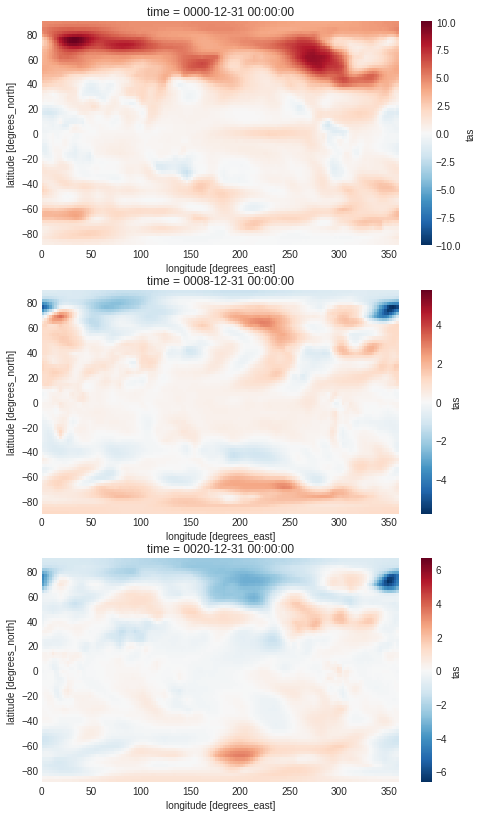

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(3, figsize=(8, 14))
control_anom.isel(time=0).plot(ax=ax1)
control_anom.isel(time=8).plot(ax=ax2)
control_anom.isel(time=20).plot(ax=ax3)

# QuadCO2
Running the same codes as above, but for a run where the CO2 has been quadrupled. 

In [13]:
abrupt = xr.open_dataset(os.path.join(ROOT_DIR,'tas_mon_CCSM3_abrupt4x_2120_g025.nc' )).tas
abrupt 

<xarray.DataArray 'tas' (time: 2120, lat: 72, lon: 144)>
[21980160 values with dtype=float32]
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 2119-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [14]:
abrupt.time.values[:3]

array([cftime.DatetimeNoLeap(0, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [15]:
# Getting the temperature anomalies. The start and end year are the start and of the control
# period. The anomalies are compared to the control run here.
abrupt_anom = abrupt.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1],
                            historical = control)

Using historical dataset


In [16]:
abrupt_anom 

<xarray.DataArray 'tas' (time: 2120, lat: 72, lon: 144)>
dask.array<xarray-<this-array>, shape=(2120, 72, 144), dtype=float32, chunksize=(8, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 2119-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

# Global Mean

Calculating the s/n for the global mean. Each grid cell is then compared with the global mean.

## Control Bounds

In [17]:
control_anom

<xarray.DataArray 'tas' (time: 1530, lat: 72, lon: 144)>
dask.array<xarray-<this-array>, shape=(1530, 72, 144), dtype=float32, chunksize=(8, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1529-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [18]:
# Getting the space mean of the anomalies.
control_anom_smean = control_anom.clima.space_mean()
control_anom_smean

<xarray.DataArray 'tas' (time: 1530)>
dask.array<truediv, shape=(1530,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1529-12-31 00:00:00

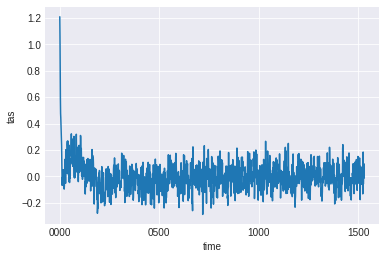

In [19]:
# The mean anomalies for control.
control_anom_smean.plot()

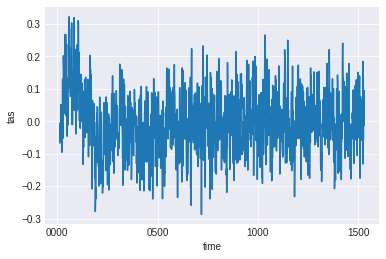

In [20]:
# The first year seems to be incomplete. Revmoign teh first 12 timesteps gets rid of this.
control_anom_smean = control_anom_smean.isel(time=slice(12,None))
control_anom_smean.plot()

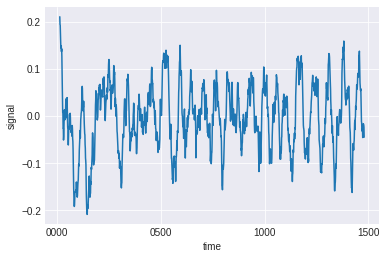

In [21]:
# The mean signal of the anomalies.
control_anom_smean_signal = control_anom_smean.sn.signal_grad(roll_period = WINDOW)
control_anom_smean_signal.plot()

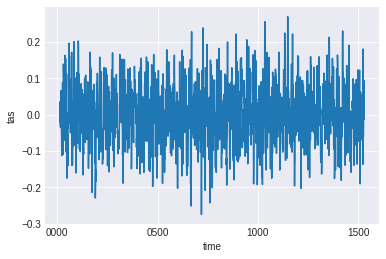

In [22]:
# Applying the loess filter to the space mean anomalies.
control_anom_smean_loess = control_anom_smean.sn.loess_grid(step_size=WINDOW)
control_anom_smean_loess.plot()

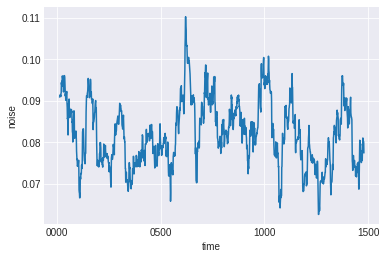

In [23]:
# The noise of the loess filtered control anomlalies.
control_anom_smean_noise = control_anom_smean_loess.sn.noise_grad(roll_period=WINDOW)
control_anom_smean_noise.plot()

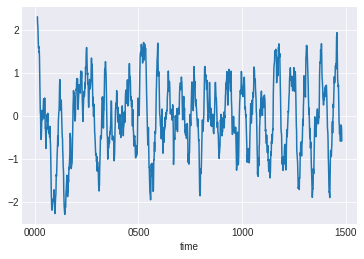

In [24]:
# The signal to noise for the control anomlaies.
control_anom_smean_sn = control_anom_smean_signal/control_anom_smean_noise
control_anom_smean_sn.plot()

In [25]:
control_anom_smean_sn

<xarray.DataArray (time: 1468)>
dask.array<truediv, shape=(1468,), dtype=float64, chunksize=(56,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0012-12-31 00:00:00 ... 1479-12-31 00:00:00

In [26]:
# The lower and upper bounds of what is defined as a normal climate.
control_smean_ubound = control_anom_smean_sn.reduce(np.nanpercentile, q=99, dim='time')
control_smean_lbound = control_anom_smean_sn.reduce(np.nanpercentile, q=1, dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:1650: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:1650: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [27]:
control_smean_ubound

<xarray.DataArray ()>
array(1.6575115)

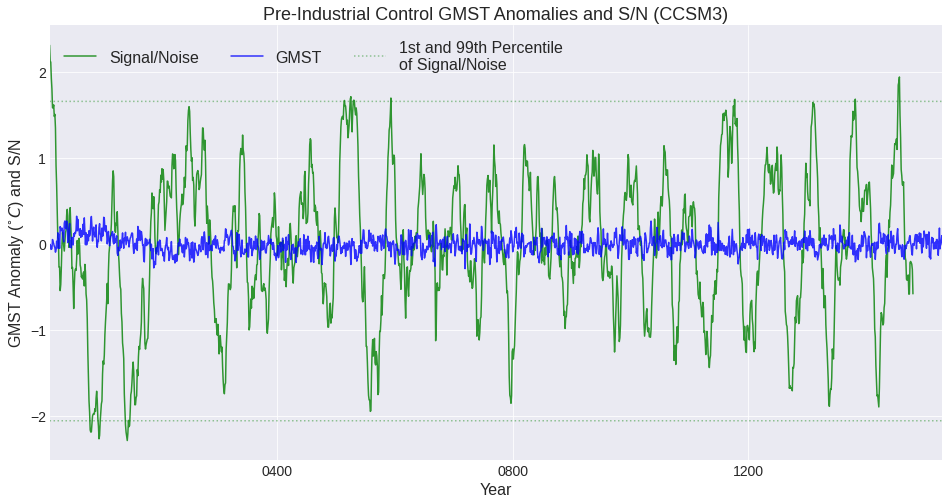

In [28]:
fig = plt.figure(figsize=(16,8))
ax = plt.gca()
control_anom_smean_sn.plot(label='Signal/Noise', ax=ax, color='green', alpha=0.8)
control_anom_smean.plot(label='GMST', ax=ax, color='blue', alpha=0.8)

time = control_anom_smean.time.values

ax.plot(time, [control_smean_lbound.values] * len(control_anom_smean.time.values), 
        label='1st and 99th Percentile\nof Signal/Noise',
       c='green', linestyle =':', alpha=0.4)

ax.plot(time, [control_smean_ubound.values] * len(control_anom_smean.time.values),
       c='green', linestyle =':', alpha=0.4)

ax.set_xlim(time[0], time[-1])
ax.legend(ncol=4, fontsize=16)
ax.set_ylabel(r'GMST Anomaly ($^{\circ}C$) and S/N', size=16);
ax.set_xlabel('Year', size=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(f'Pre-Industrial Control GMST Anomalies and S/N ({model})', size=18)

fig.savefig(f'{IMG_DIR}/02_piControl_SN.png', dpi=200)

In [29]:
print(control_smean_lbound.values, control_smean_ubound.values)

-2.0554624909029475 1.6575114950108827


## Abrupt Values

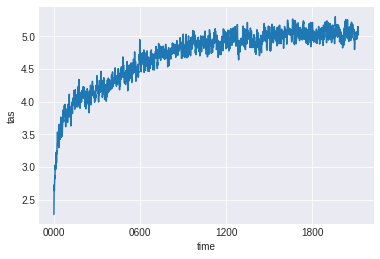

In [30]:
# THe space mean of the signal to noise values
abrupt_anom_smean = abrupt_anom.clima.space_mean()
abrupt_anom_smean.plot()

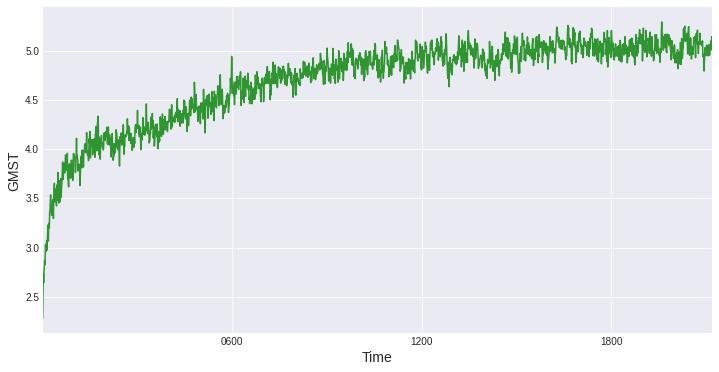

In [31]:
# A nice plot of the space mean
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
abrupt_anom_smean.plot(ax = ax, color='green', alpha = 0.8)
ax.set_xlim(abrupt_anom_smean.time.values[0], abrupt_anom_smean.time.values[-1])
ax.set_xlabel('Time', size=14)
ax.set_ylabel('GMST', size=14)
fig.savefig(f'{IMG_DIR}/02_GMST.png', dpi=200)

In [32]:
# Sample period is the years that we want to look at
sample_period = (0,61) #(1200,1261)

# The length of the sample_period varible
window_length = np.diff(sample_period)[0]

In [33]:
# Getting just the data for the sample period.
sample_data = abrupt_anom_smean.isel(time=slice(*sample_period))
sample_data

<xarray.DataArray 'tas' (time: 61)>
dask.array<getitem, shape=(61,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0060-12-31 00:00:00

In [34]:
# Gradient and y-intercept of the sample data (use=[0,1] will return grad and y intercept)
gradient_sp, yintercept_sp = xca.SignalToNoise._grid_trend(sample_data.values, use=[0,1])
print(gradient_sp, yintercept_sp)

0.01642268225984055 2.811899829831217


In [35]:
# Trend line (fitted_line) for the sample data to demonstrate method is working.
x_values = np.arange(len(sample_data.time.values))
fitted_line = gradient_sp * x_values + yintercept_sp
fitted_line[:5]

array([2.81189983, 2.82832251, 2.84474519, 2.86116788, 2.87759056])

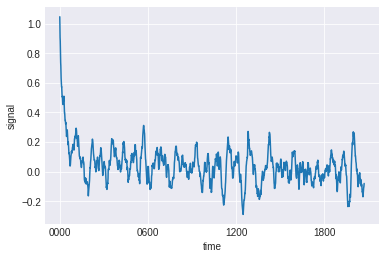

In [36]:
abrupt_anom_smean_signal = abrupt_anom_smean.sn.signal_grad(roll_period = WINDOW)
abrupt_anom_smean_signal.plot()

In [37]:
# Calculating the signal for the sample point
signal_sp = gradient_sp * window_length
signal_sp

1.0017836178502735

In [38]:
abrupt_anom_smean_signal.isel(time=0).values

array(1.04699746)

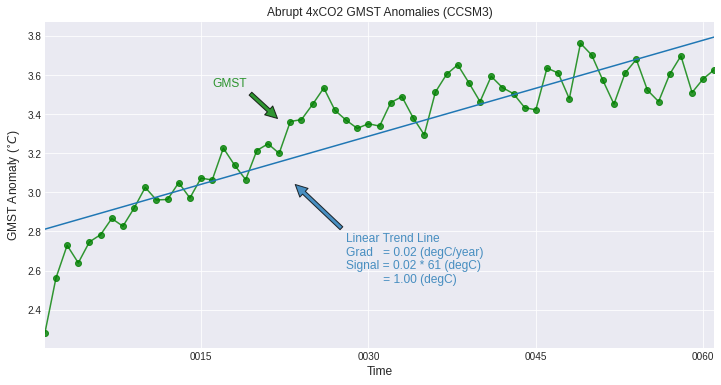

In [39]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
sample_data.plot(ax = ax, color='green', alpha = 0.8, marker='o', label='GMST')
ax.plot(sample_data.time.values, fitted_line,
        label=f'Linear Trend Line\nGrad = {gradient_sp:.2f}\nSignal {signal_sp:.2f}')
ax.set_xlim(sample_data.time.values[0], sample_data.time.values[-1])
ax.set_xlabel('Time', size=12)
ax.set_ylabel(r'GMST Anomaly ($^{\circ}C$)', size=12)
# ax.legend(ncol=2);


c_gmst = plt.gca().lines[0].get_color()
ax.annotate('GMST', xy = (0.35, 0.7), xycoords='axes fraction', size=12, c=c_gmst, alpha=0.8,
            xytext = (0.25, 0.8),
           arrowprops=dict(facecolor=c_gmst, shrink=0.05, alpha=0.8))


c_line = plt.gca().lines[1].get_color()
text = f'Linear Trend Line\nGrad   = {gradient_sp:.2f} (degC/year)\nSignal = {gradient_sp:.2f} * {window_length} (degC)\n           = {signal_sp:.2f} (degC)'
ax.annotate(text,
            xy = (0.37, 0.51), xycoords='axes fraction', size=12, c=c_line, alpha=0.8,
            xytext = (0.45, 0.2),
           arrowprops=dict(facecolor=c_line, shrink=0.05, alpha=0.8))

ax.set_title(f'Abrupt 4xCO2 GMST Anomalies ({model})');


# fig.savefig(f'{IMG_DIR}/02_GMST_Signal.png', dpi=200)

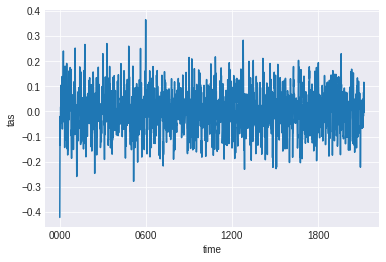

In [40]:
# Loess filtering the 4xabrupt anomalies space mean. 
abrupt_anom_smean_loess = abrupt_anom_smean.sn.loess_grid(step_size= WINDOW)
abrupt_anom_smean_loess.plot()

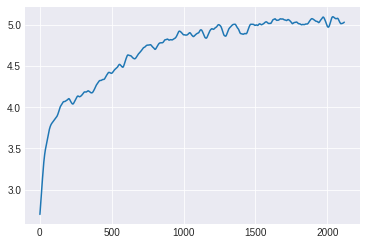

In [41]:
# Loess filtered 4xabrupt anomalies space mean. 
yhat = xca.SignalToNoise.loess_filter(abrupt_anom_smean.values, step_size = 51)

plt.plot(yhat)

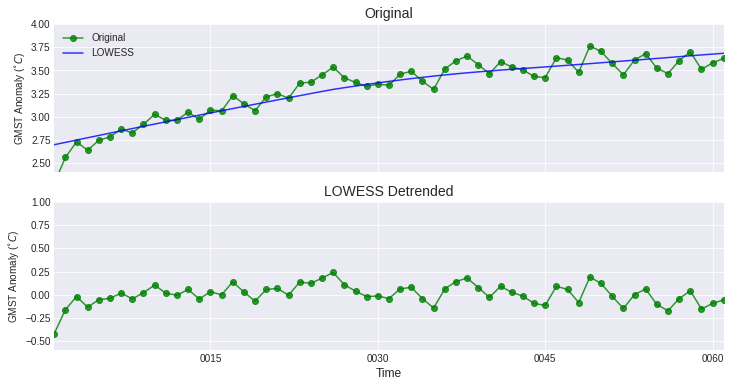

In [42]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,1,1)
abrupt_anom_smean.isel(time=slice(*sample_period)).plot(ax=ax1, label='Original', color='green', marker='o'
                                                       ,alpha=0.8)
ax1.plot(sample_data.time.values[sample_period[0]:sample_period[-1]],
         yhat[sample_period[0]:sample_period[-1]], label='LOWESS', color='blue',alpha=0.8)
ax1.set_ylim([2.4,4])
ax1.set_title('Original', fontsize=14)
ax1.set_xlabel('')
ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.set_ylabel(r'GMST Anomaly ($^{\circ}C$)')
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
abrupt_anom_smean_loess.isel(time=slice(*sample_period)).plot(ax=ax2, color='green', marker='o',alpha=0.8)
ax2.set_ylim([-0.6, 1])
ax2.set_title('LOWESS Detrended', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel(r'GMST Anomaly ($^{\circ}C$)')

ax1.set_xlim(sample_data.time.values[0], sample_data.time.values[-1]);
ax2.set_xlim(sample_data.time.values[0], sample_data.time.values[-1]);

# fig.savefig(f'{IMG_DIR}/02_GMST_lowess.png', dpi=200)

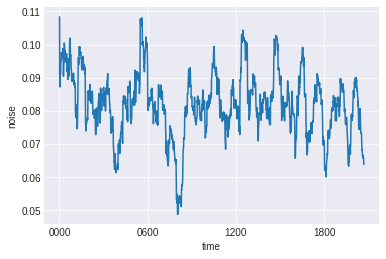

In [45]:
# Noise for the 4xabrupt anomalies space mean. 
abrupt_anom_smean_noise = abrupt_anom_smean_loess.sn.noise_grad(roll_period = WINDOW)
abrupt_anom_smean_noise.plot()

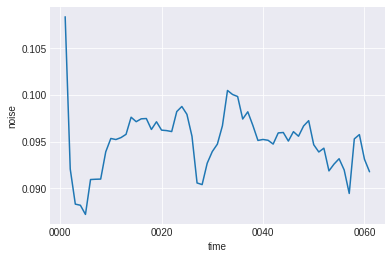

In [46]:
abrupt_anom_smean_noise.isel(time=slice(*sample_period)).plot()

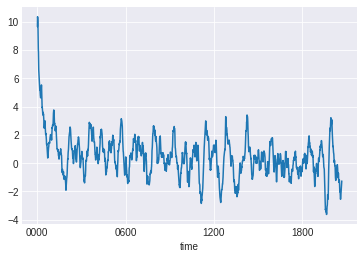

In [47]:
abrupt_anom_smean_sn = abrupt_anom_smean_signal/abrupt_anom_smean_noise
abrupt_anom_smean_sn.plot()

In [48]:
sample_period_2 = (0, 20000)

Text(0, 0.5, 'Signal to Noise')

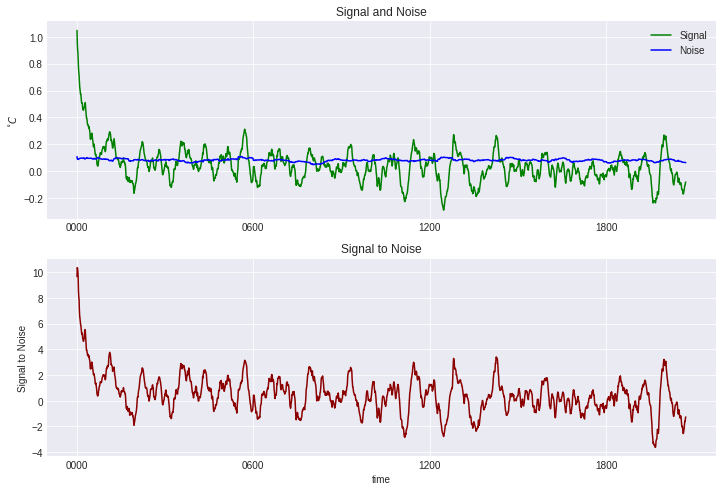

In [49]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(211)
abrupt_anom_smean_signal.isel(time=slice(*sample_period_2)).plot(ax=ax, color='green', label='Signal')
abrupt_anom_smean_noise.isel(time=slice(*sample_period_2)).plot(ax = ax, color='blue', label='Noise')
ax.set_title('Signal and Noise')
ax.set_ylabel(r'$^{\circ}C$')
ax.set_xlabel('')
ax.legend()

ax2 = fig.add_subplot(212)
abrupt_anom_smean_sn.isel(time=slice(*sample_period_2)).plot(ax = ax2, color='darkred')
ax2.set_title('Signal to Noise')
ax2.set_ylabel('Signal to Noise')

# fig.savefig(f'{IMG_DIR}/02_GMST_Signal_Npng', dpi=200)

## Global Average Stable Bounds

In [50]:
abrupt_anom_smean_sn

<xarray.DataArray (time: 2070)>
dask.array<truediv, shape=(2070,), dtype=float64, chunksize=(56,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 2069-12-31 00:00:00

In [51]:
# SN
# The global mean signal-to-noise points that are stable
abrupt_anom_smean_sn_stable = abrupt_anom_smean_sn.where(
    np.logical_and(
                        abrupt_anom_smean_sn <= control_smean_ubound,
                        abrupt_anom_smean_sn >= control_smean_lbound 
                            )
                                  )

# TEMP
# The global mean temperature anomalies that are stable
abrupt_anom_smean_stable = abrupt_anom_smean.where(
    np.logical_and(
                        abrupt_anom_smean_sn <= control_smean_ubound,
                        abrupt_anom_smean_sn >= control_smean_lbound 
                            )
                                  )

In [69]:
bounds = {'lower': control_smean_lbound.values, 'upper': control_smean_ubound.values}
bounds

{'lower': array(-2.05546249), 'upper': array(1.6575115)}

In [54]:
abrupt_anom_smean_unstable = abrupt_anom_smean.where(abrupt_anom_smean_sn >= control_smean_ubound ).compute()
abrupt_anom_smean_unstable

<xarray.DataArray 'tas' (time: 2070)>
array([2.2772212, 2.561604 , 2.7290747, ...,       nan,       nan,
             nan], dtype=float32)
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 2069-12-31 00:00:00

In [55]:
sn_plot.temperature_vs_sn_plot

<function sn_plotting.temperature_vs_sn_plot(ax, sn: xarray.core.dataarray.DataArray = None, temp: xarray.core.dataarray.DataArray = None, temp_highlight: xarray.core.dataarray.DataArray = None, sn_highlight: xarray.core.dataarray.DataArray = None)>

In [201]:
model

'CCSM3'

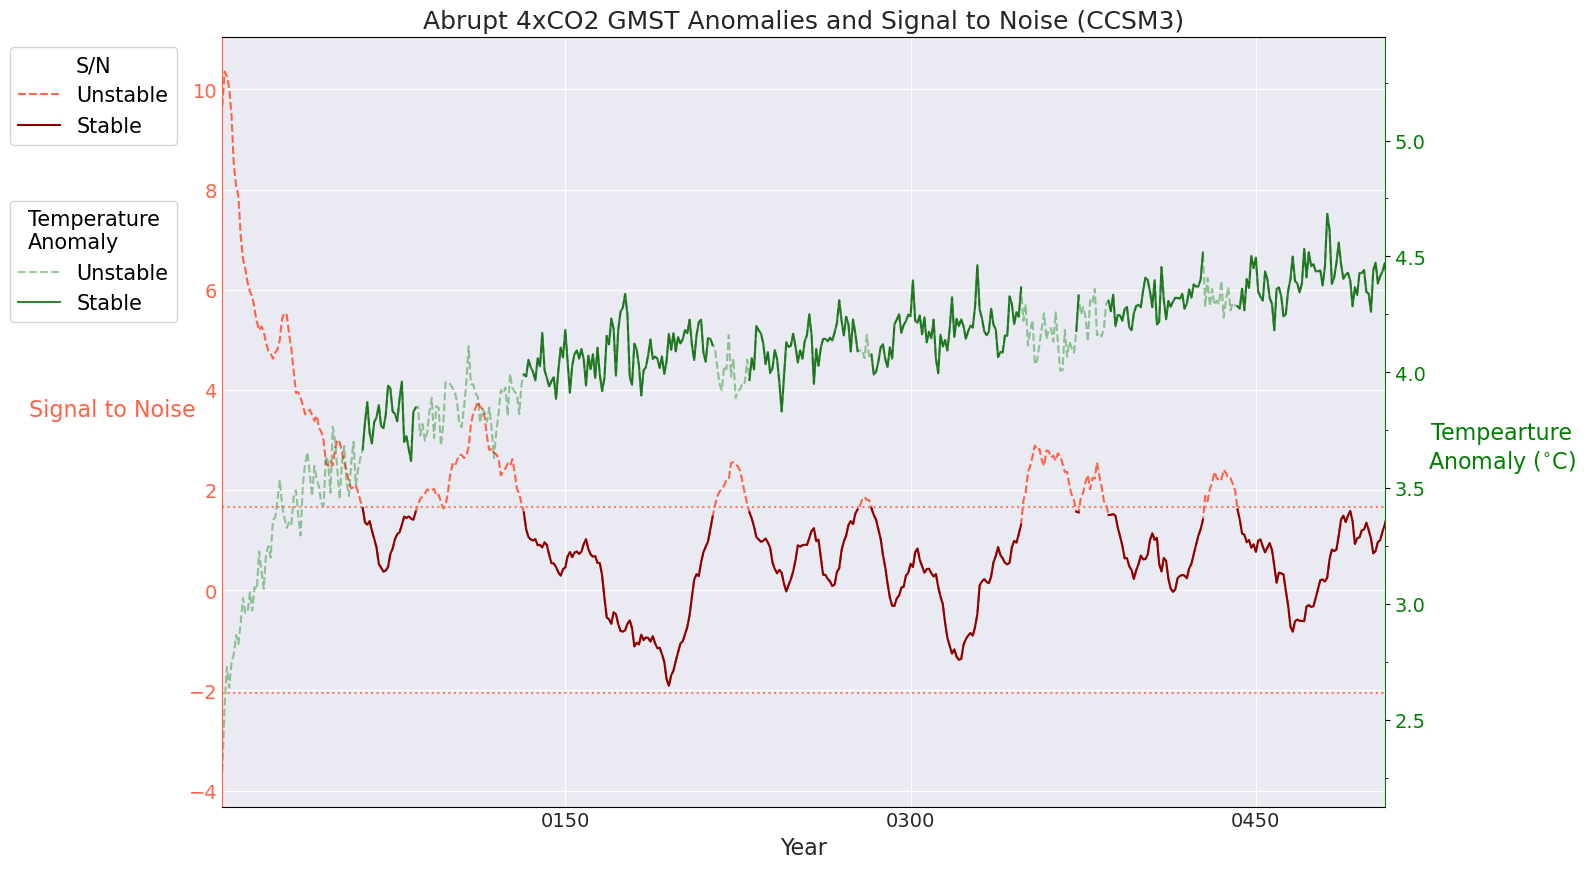

In [81]:
plt.style.use('seaborn-darkgrid')
reload(sn_plot)

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plot.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn, abrupt_anom_smean,
                      temp_highlight = abrupt_anom_smean_stable, 
                      sn_highlight = abrupt_anom_smean_sn_stable, 
                              bounds = bounds)

ax.set_xlim(abrupt_anom_smean_sn.time.values[0], abrupt_anom_smean_sn.time.values[505])
ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=18);

fig.savefig(f'{IMG_DIR}/02_{model}_global_sn_temp_anomaly_t500.png', bbox_inches='tight', dpi=200)

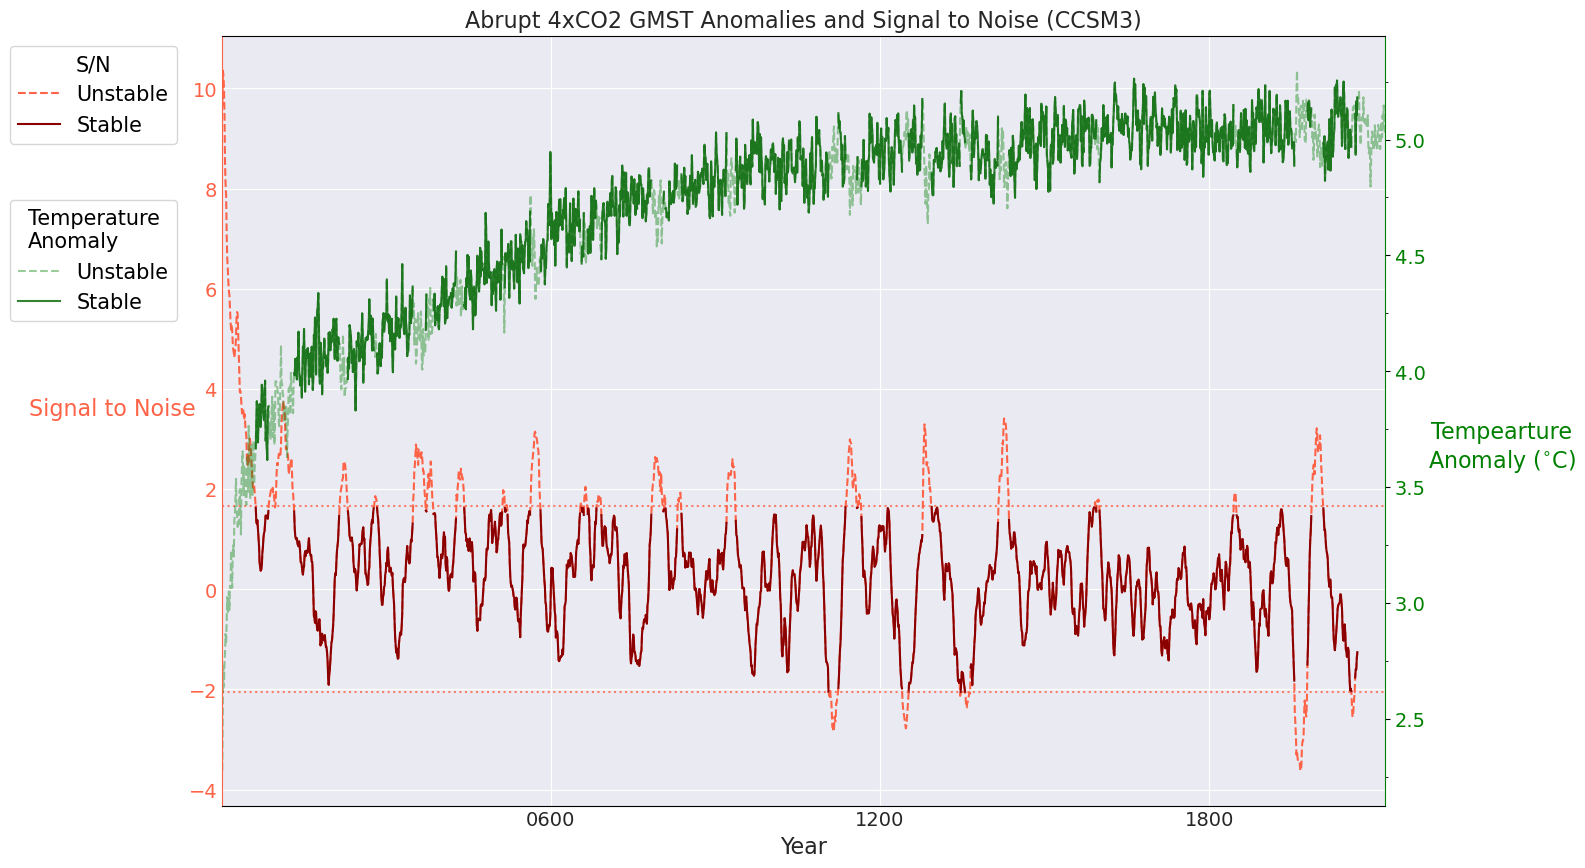

In [82]:
plt.style.use('seaborn-darkgrid')
reload(sn_plot)

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plot.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn, abrupt_anom_smean,
                      temp_highlight = abrupt_anom_smean_stable, 
                      sn_highlight = abrupt_anom_smean_sn_stable, bounds=bounds)

ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=16);

fig.savefig(f'{IMG_DIR}/02_{model}_global_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)

# Consecutive Metrics

In [114]:
control_anom_smean_sn

<xarray.DataArray (time: 1468)>
dask.array<truediv, shape=(1468,), dtype=float64, chunksize=(56,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0012-12-31 00:00:00 ... 1479-12-31 00:00:00

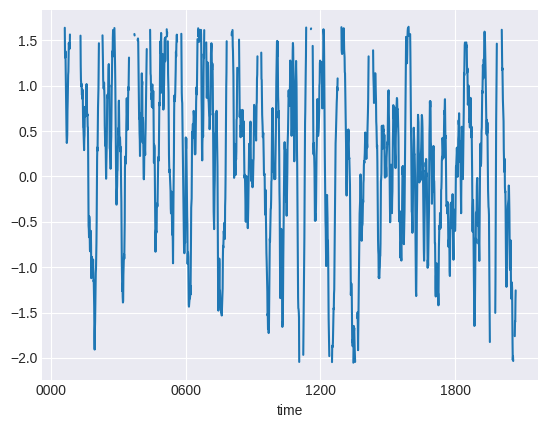

In [115]:
abrupt_anom_smean_sn_stable.plot()

In [116]:
abrupt_anom_smean_sn_stable = abrupt_anom_smean_sn_stable.compute()

In [117]:
abrupt_anom_smean_sn_stable

<xarray.DataArray (time: 2070)>
array([        nan,         nan,         nan, ..., -1.60138237,
       -1.36978147, -1.25607149])
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 2069-12-31 00:00:00

In [121]:
reload(xca)
#The consecutive metrics
stable_smean_ds = abrupt_anom_smean_sn_stable.sn.calculate_consecutive_metrics(logginglevel='DEBUG')

New data has shape (5,)


In [119]:
stable_smean_ds

<xarray.Dataset>
Dimensions:              ()
Coordinates:
    time                 object 0000-12-31 00:00:00
Data variables:
    first_stable         float64 61.0
    average_length       float64 48.53
    number_periods       float64 34.0
    total_time_stable    float64 1.65e+03
    percent_time_stable  float64 79.71

In [120]:
stable_smean_ds.first_stable.values

array(61.)